In [1]:
import gzip
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader

In [2]:
data_transform = {
    'train' : transforms.Compose([
        transforms.RandomRotation(10), #random rotation 10 degrees
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ]),

    'test' : transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ]),
}

In [3]:
data_dir = 'dataset/gzip'

In [4]:
image_datasets = {
    'train': datasets.EMNIST(
        root = data_dir,
        split = 'balanced',
        train = True,
        download = True,
        transform = data_transform['train']
    ),

    'test': datasets.EMNIST(
        root = data_dir,
        split = 'balanced',
        train = False,
        download = True,
        transform = data_transform['test']
    )
}


In [5]:
dataloaders = {
    x: DataLoader(image_datasets[x], batch_size=64, shuffle=(x == 'train'))
    for x in ['train', 'test']
}

In [6]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

In [7]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), cmap = 'gray')
    plt.show()

In [8]:
dataiterator = iter(dataloaders['train'])
images, labels = next(dataiterator)

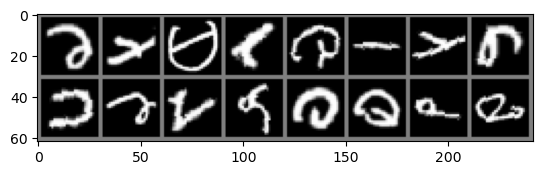

In [9]:
imshow(utils.make_grid(images[:16]))